In [11]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from PIL import Image

In [12]:
#get the 4 points of the images 1a,1b and 1c. Also return a vector X_prime=[x1,y1,x2,y2,x3,y3,x4,y4]
def get_4_points(n):
  if n==1:  #image 1a
    #for the image
    P=[295,507]   #x1,y1
    Q=[236,1602]  #x2,y2
    R=[1680,1824] #x3,y3
    S=[1771,359]  #x4,y4
    X_prime=P+Q+R+S
    return np.array([P,Q,R,S]),X_prime
  
  if n==2:    #image 1b
    #for the image
    P=[336,691]
    Q=[332,2330]
    R=[1881,1998]
    S=[1885,749]
    X_prime=P+Q+R+S
    return np.array([P,Q,R,S]),X_prime

  if n==3:    #image 1c
    #for the image
    P=[107,438]   #x1,y1
    Q=[119,1361]  #x2,y2
    R=[1093,1859] #x3,y3
    S=[1212,301]  #x4,y4
    X_prime=P+Q+R+S
    return np.array([P,Q,R,S]),X_prime

#get the 4 corner points of the cat image
def get_cat_points():
  #for the kittens
  P_dash=[0,0]
  Q_dash=[0,1125]
  R_dash=[1920,1125]
  S_dash=[1920,0]
  X=P_dash+Q_dash+R_dash+S_dash
  return np.array([P_dash,Q_dash,R_dash,S_dash]),X

In [13]:
#to check to validitiy of the 4 points, we draw a bounding box aroud the image.
def draw_bbox(image,points):
  copy_image=image.copy()
  #draw bounding box to check correctnes of the points
  points_reshape = points.reshape((-1, 1, 2))
  color = (255, 0, 0) 
  im1_bbox = cv2.polylines(copy_image, [points_reshape], isClosed=True,color=color,thickness = 10)
  cv2.imwrite("bbox.jpg",im1_bbox) 
  plt.axis('off')  
  plt.imshow(im1_bbox) 

In [14]:
def Homography_matrix(X_prime,X):
  '''
  This function takes input X and X_prime and computes the homography between them. Returns a 3x3 non-singular matrix
  H. 
  '''
  H = np.ones((3,3))  #Initialise the Homography matrix
  A = np.zeros((8,8)) #initialise a matrix
   

  C=X_prime   

  #build the A matrix column by column
  for i in range(0,4):
    A[2*i,0]=X[2*i]
    A[2*i,1]=X[2*i+1]
    A[2*i,2]=1
    A[2*i+1,3]=X[2*i]
    A[2*i+1,4]=X[2*i+1]
    A[2*i+1,5]=1
    A[2*i,6]=X[2*i]*X_prime[2*i]
    A[2*i+1,6]=X[2*i]*X_prime[2*i+1]
    A[2*i,7]=(X[2*i+1]*X_prime[2*i])
    A[2*i+1,7]=(X[2*i+1]*X_prime[2*i+1])
  A[:,6:]=-A[:,6:]
  
  #B=(A^-1)C
  B=np.dot(np.linalg.inv(A),C)

  #reshape the B vector to get the homography matrix
  H[0,0]=B[0]
  H[0,1]=B[1]
  H[0,2]=B[2]
  H[1,0]=B[3]
  H[1,1]=B[4]
  H[1,2]=B[5]
  H[2,0]=B[6]
  H[2,1]=B[7]
  H[2,2]=1
  return H

In [15]:
def get_mask_image(image,image_points):
    '''
    This function returns a binary image of the passed image with all points outside the bounding box 0. This is done
    to make it easier to pick the pixels that are present inside the bounding box during projection.
    '''
    mask_image = np.zeros(image.shape,dtype='uint8')
    image_points_reshape=image_points.reshape((-1, 1, 2))
    mask_image = cv2.fillPoly(mask_image,[image_points_reshape],(255,255,255))
    plt.imshow(mask_image)
    return mask_image

In [16]:
def Homography_mapping(im1,cat,H,image_filled):
  '''
  This function maps each pixel in the domain to the corresponding pixel in the range using the equation: X'=HX where 
  X, X' are the homogeneous coordinates of the pixels in the domain and range.
  '''
  for i in range(cat.shape[1]): #X-cordinate
    for j in range(cat.shape[0]): #Y-coordinate
            Image_homo = np.array((i,j,1))  #create the homogeneous vector
            Image_mapped = np.matmul(H, Image_homo)   #HX
            Image_mapped = Image_mapped/Image_mapped[2]   #divide by x3 to get world coordinates
            Image_mapped = Image_mapped.astype(int)     #convert floating values to integer
            im1[Image_mapped[1],Image_mapped[0]] = cat[j,i]   #replace the range pixels with corresponding pixels from the domain

  plt.imshow(im1)
  im1=cv2.cvtColor(im1, cv2.COLOR_RGB2BGR)
  cv2.imwrite("output.jpg",im1)

In [17]:
def Homography_mapping2(im1,cat,H,image_filled):
  '''
  This function maps each pixel in the domain to the corresponding pixel in the range using the equation: X'=HX where 
  X, X' are the homogeneous coordinates of the pixels in the domain and range. This function finds the projection of 
  image 1a onto the cat image. Running Homography_mapping and Homography_mapping2 shows better results for Homography_mapping2
  as all the pixels of the range image has a corresponding pixel in the domain image.
  '''
  for i in range(0,im1.shape[1]):
    for j in range(0,im1.shape[0]):
      if any(image_filled[j][i]) > 0:
        #traverse only through the points inside the bbox. accomplised using mask image.
        Image_homo = np.array((i,j,1))
        Image_mapped = np.matmul(H, Image_homo)
        Image_mapped = np.rint(Image_mapped/Image_mapped[2])
        Image_mapped = Image_mapped.astype(int)
        if(Image_mapped[0] < cat.shape[1] and Image_mapped[1] < cat.shape[0]):
          #check if all projected pixels do not exceed the image boundary 
          im1[j,i] = cat[Image_mapped[1],Image_mapped[0]]
  return im1

Task 1.a

[[ 1.88698160e+00  1.01672981e-01 -6.08207774e+02]
 [ 1.10871535e-01  1.10571883e+00 -5.93306548e+02]
 [ 2.48528043e-04  7.34442954e-06  1.00000000e+00]]


True

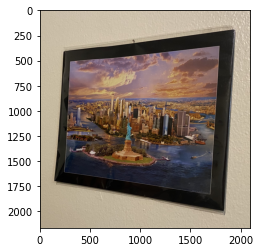

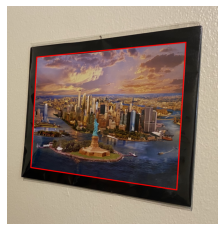

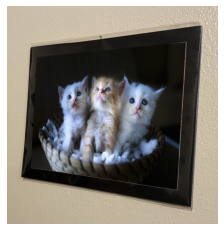

In [18]:
#read and display the images
im1=cv2.imread("/content/drive/My Drive/hw2_Task1_Images/painting1.jpeg")
im1 = cv2.cvtColor(im1, cv2.COLOR_BGR2RGB)

plt.figure()
plt.imshow(im1)

cat=cv2.imread("/content/drive/My Drive/hw2_Task1_Images/kittens.jpeg")
cat = cv2.cvtColor(cat, cv2.COLOR_BGR2RGB)
plt.figure()
plt.imshow(cat)

#get the 4 corner points and draw a bounding box around them
P1,X_prime=get_4_points(1)
P_cat,X=get_cat_points()
draw_bbox(im1,P1)
plt.figure()
draw_bbox(cat,P_cat)

#get the Homography matrix
H=Homography_matrix(X,X_prime)
print(H)

#get the mask image 
image_filled=get_mask_image(im1,P1)

#project the domain image to range image
projected_image=Homography_mapping2(im1,cat,H,image_filled)
plt.imshow(projected_image)
projected_image=cv2.cvtColor(projected_image, cv2.COLOR_RGB2BGR)
cv2.imwrite("output1.jpg",projected_image)

In [19]:
H_inv=np.linalg.inv(H)
np.matmul(H_inv,np.array([1920,1125,1]).T)

array([1.17406708e+03, 1.27470140e+03, 6.98849452e-01])

Task 1.b

[[ 8.97453617e-01  2.19024678e-03 -3.03057876e+02]
 [-2.44033560e-02  6.51737905e-01 -4.42151364e+02]
 [-1.46035725e-04 -8.23888532e-07  1.00000000e+00]]


True

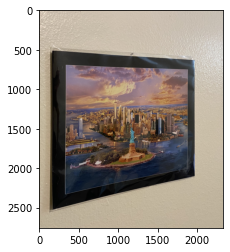

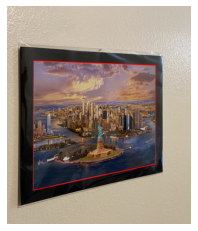

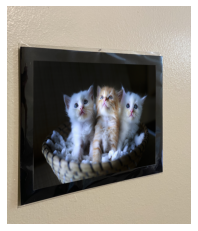

In [20]:
im1=cv2.imread("/content/drive/My Drive/hw2_Task1_Images/painting2.jpeg")
im1 = cv2.cvtColor(im1, cv2.COLOR_BGR2RGB)

plt.figure()
plt.imshow(im1)

cat=cv2.imread("/content/drive/My Drive/hw2_Task1_Images/kittens.jpeg")
cat = cv2.cvtColor(cat, cv2.COLOR_BGR2RGB)
plt.figure()
plt.imshow(cat)

P1,X_prime=get_4_points(2)
P_cat,X=get_cat_points()
draw_bbox(im1,P1)
plt.figure()
draw_bbox(cat,P_cat)

H=Homography_matrix(X,X_prime)
print(H)

image_filled=get_mask_image(im1,P1)
projected_image=Homography_mapping2(im1,cat,H,image_filled)
plt.imshow(projected_image)
projected_image=cv2.cvtColor(projected_image, cv2.COLOR_RGB2BGR)
cv2.imwrite("output2.jpg",projected_image)

Task 1.c

[[ 3.16841553e+00 -4.11928347e-02 -3.20978001e+02]
 [ 1.44304182e-01  1.16391329e+00 -5.25234568e+02]
 [ 7.05127241e-04 -9.36404889e-05  1.00000000e+00]]


True

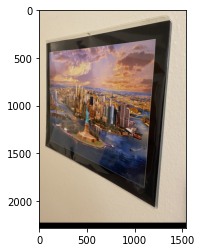

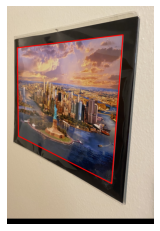

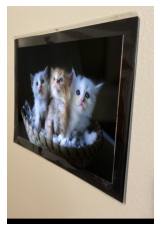

In [21]:
im1=cv2.imread("/content/drive/My Drive/hw2_Task1_Images/painting3.jpeg")
im1 = cv2.cvtColor(im1, cv2.COLOR_BGR2RGB)

plt.figure()
plt.imshow(im1)

cat=cv2.imread("/content/drive/My Drive/hw2_Task1_Images/kittens.jpeg")
cat = cv2.cvtColor(cat, cv2.COLOR_BGR2RGB)
plt.figure()
plt.imshow(cat)

P1,X_prime=get_4_points(3)
P_cat,X=get_cat_points()
draw_bbox(im1,P1)
plt.figure()
draw_bbox(cat,P_cat)

H=Homography_matrix(X,X_prime)
print(H)

image_filled=get_mask_image(im1,P1)
projected_image=Homography_mapping2(im1,cat,H,image_filled)
plt.imshow(projected_image)
projected_image=cv2.cvtColor(projected_image, cv2.COLOR_RGB2BGR)
cv2.imwrite("output3.jpg",projected_image)

Task 1.d

True

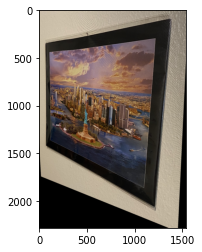

In [22]:
#read an display the three images
im2=cv2.imread("/content/drive/My Drive/hw2_Task1_Images/painting2.jpeg")
im2 = cv2.cvtColor(im2, cv2.COLOR_BGR2RGB)

im1=cv2.imread("/content/drive/My Drive/hw2_Task1_Images/painting1.jpeg")
im1 = cv2.cvtColor(im1, cv2.COLOR_BGR2RGB)

im3=cv2.imread("/content/drive/My Drive/hw2_Task1_Images/painting3.jpeg")
im3 = cv2.cvtColor(im3, cv2.COLOR_BGR2RGB)

#get the 4 corner points
P1,X1=get_4_points(1)
P2,X2=get_4_points(2)
P3,X3=get_4_points(3)

#Find the hoography between im1 and im2 and im2 and im3.
#H1=Homography_matrix(X1,X2)
#H2=Homography_matrix(X2,X3)
H1=Homography_matrix(X2,X1)
H2=Homography_matrix(X3,X2)
H=np.matmul(H2,H1)  #multiply H1 and H2 to get a combined H matrix

#define a blank image of the shape im3.
blank_image=np.zeros(im3.shape,dtype='uint8')

#project the image im1 onto this blank image
for i in range(0,im1.shape[1]): #X-cordinate, col
    for j in range(0,im1.shape[0]): #Y-coordinate, row
            im1_homo=np.array((i,j,1))
            mapped_image = np.matmul(H, im1_homo)
            mapped_image = np.rint(mapped_image/mapped_image[-1]) #Normalize and round off to nearest integer
            mapped_image = mapped_image.astype(int)
            if(mapped_image[0] > 0 and mapped_image[1] > 0 and mapped_image[0] < im3.shape[1] and mapped_image[1] < im3.shape[0]):
              blank_image[mapped_image[1],mapped_image[0]] = im1[j,i]

plt.imshow(blank_image)
blank_image=cv2.cvtColor(blank_image, cv2.COLOR_RGB2BGR)
cv2.imwrite("output4.jpg",blank_image)

Task 2

Perform the same operations as done in task 1 but on custom images of your own.

In [23]:
def get_4_points(n):
  if n==1:
    #for the image
    P=[1609,866]   #x1,y1
    Q=[1437,2201]  #x2,y2
    R=[2919,2270] #x3,y3
    S=[2924,566]  #x4,y4
    X_prime=P+Q+R+S
    return np.array([P,Q,R,S]),X_prime
  
  if n==2:
    #for the image
    P=[1939,753]
    Q=[1890,2275]
    R=[2717,2235]
    S=[2702,1108]
    X_prime=P+Q+R+S
    return np.array([P,Q,R,S]),X_prime

  if n==3:
    #for the image
    P=[1860,925]   #x1,y1
    Q=[1491,1979]  #x2,y2
    R=[2505,2462] #x3,y3
    S=[2929,1162]  #x4,y4
    X_prime=P+Q+R+S
    return np.array([P,Q,R,S]),X_prime

def get_cat_points():
  #for the kittens
  P_dash=[0,0]
  Q_dash=[0,1493]
  R_dash=[1376,1493]
  S_dash=[1376,0]
  X=P_dash+Q_dash+R_dash+S_dash
  return np.array([P_dash,Q_dash,R_dash,S_dash]),X

Task 2.a

[[ 2.65276940e+00  3.41780028e-01 -4.56428747e+03]
 [ 5.74914384e-01  2.52004138e+00 -3.10739308e+03]
 [ 4.52296939e-04  2.44056872e-04  1.00000000e+00]]


True

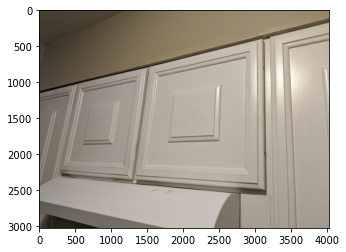

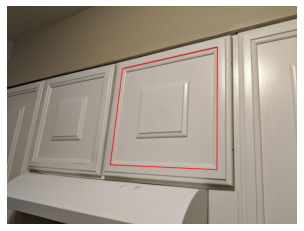

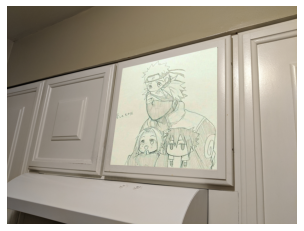

In [24]:
im1=cv2.imread("/content/drive/My Drive/hw2_Task1_Images/im1.jpg")
im1 = cv2.cvtColor(im1, cv2.COLOR_BGR2RGB)

plt.figure()
plt.imshow(im1)

cat=cv2.imread("/content/drive/My Drive/hw2_Task1_Images/naruto.png")
cat = cv2.cvtColor(cat, cv2.COLOR_BGR2RGB)
plt.figure()
plt.imshow(cat)

P1,X_prime=get_4_points(1)
P_cat,X=get_cat_points()
draw_bbox(im1,P1)
plt.figure()
draw_bbox(cat,P_cat)

H=Homography_matrix(X,X_prime)
print(H)

image_filled=get_mask_image(im1,P1)
projected_image=Homography_mapping2(im1,cat,H,image_filled)
plt.imshow(projected_image)
projected_image=cv2.cvtColor(projected_image, cv2.COLOR_RGB2BGR)
cv2.imwrite("output21.jpg",projected_image)

Task 2.b

[[ 7.93073988e-01  2.55326054e-02 -1.55699651e+03]
 [-2.95162685e-01  6.34391912e-01  9.46233368e+01]
 [-2.16841505e-04  2.91129496e-05  1.00000000e+00]]


True

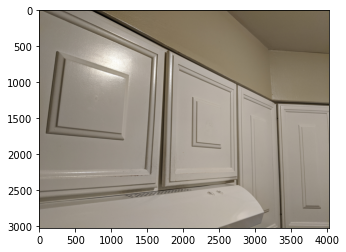

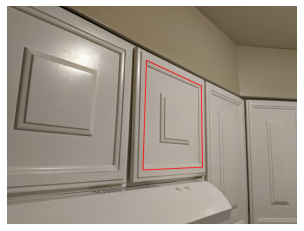

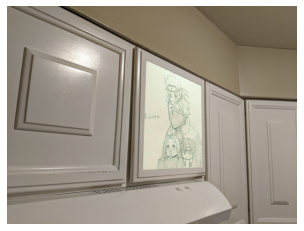

In [25]:
im1=cv2.imread("/content/drive/My Drive/hw2_Task1_Images/im2.jpg")
im1 = cv2.cvtColor(im1, cv2.COLOR_BGR2RGB)

plt.figure()
plt.imshow(im1)

cat=cv2.imread("/content/drive/My Drive/hw2_Task1_Images/naruto.png")
cat = cv2.cvtColor(cat, cv2.COLOR_BGR2RGB)
plt.figure()
plt.imshow(cat)

P1,X_prime=get_4_points(2)
P_cat,X=get_cat_points()
draw_bbox(im1,P1)
plt.figure()
draw_bbox(cat,P_cat)

H=Homography_matrix(X,X_prime)
print(H)

image_filled=get_mask_image(im1,P1)
projected_image=Homography_mapping2(im1,cat,H,image_filled)
plt.imshow(projected_image)
projected_image=cv2.cvtColor(projected_image, cv2.COLOR_RGB2BGR)
cv2.imwrite("output22.jpg",projected_image)

Task 2.c

[[ 2.55734192e+00  8.95312305e-01 -5.58481986e+03]
 [-5.22104430e-01  2.35497736e+00 -1.20723982e+03]
 [ 3.29286252e-04  1.51893182e-04  1.00000000e+00]]


True

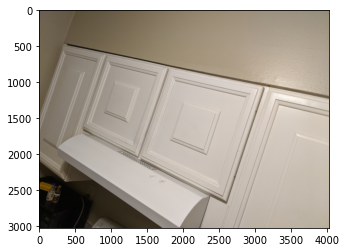

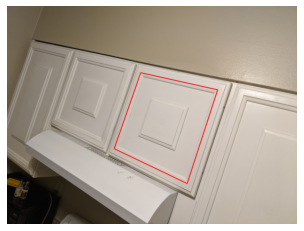

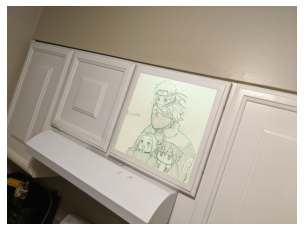

In [26]:
im1=cv2.imread("/content/drive/My Drive/hw2_Task1_Images/im3.jpg")
im1 = cv2.cvtColor(im1, cv2.COLOR_BGR2RGB)

plt.figure()
plt.imshow(im1)

cat=cv2.imread("/content/drive/My Drive/hw2_Task1_Images/naruto.png")
cat = cv2.cvtColor(cat, cv2.COLOR_BGR2RGB)
plt.figure()
plt.imshow(cat)

P1,X_prime=get_4_points(3)
P_cat,X=get_cat_points()
draw_bbox(im1,P1)
plt.figure()
draw_bbox(cat,P_cat)

H=Homography_matrix(X,X_prime)
print(H)

image_filled=get_mask_image(im1,P1)
projected_image=Homography_mapping2(im1,cat,H,image_filled)
plt.imshow(projected_image)
projected_image=cv2.cvtColor(projected_image, cv2.COLOR_RGB2BGR)
cv2.imwrite("output23.jpg",projected_image)

Task 2.d

True

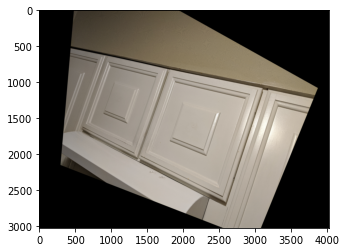

In [27]:
im2=cv2.imread("/content/drive/My Drive/hw2_Task1_Images/im2.jpg")
im2 = cv2.cvtColor(im2, cv2.COLOR_BGR2RGB)

im1=cv2.imread("/content/drive/My Drive/hw2_Task1_Images/im1.jpg")
im1 = cv2.cvtColor(im1, cv2.COLOR_BGR2RGB)

im3=cv2.imread("/content/drive/My Drive/hw2_Task1_Images/im3.jpg")
im3 = cv2.cvtColor(im3, cv2.COLOR_BGR2RGB)

P1,X1=get_4_points(1)
P2,X2=get_4_points(2)
P3,X3=get_4_points(3)

H1=Homography_matrix(X2,X1)
H2=Homography_matrix(X3,X2)
H=np.matmul(H2,H1)

blank_image=np.zeros(im3.shape,dtype='uint8')
for i in range(0,im1.shape[1]): #X-cordinate, col
    for j in range(0,im1.shape[0]): #Y-coordinate, row
            im1_homo=np.array((i,j,1))
            mapped_image = np.matmul(H, im1_homo)
            mapped_image = np.rint(mapped_image/mapped_image[-1]) #Normalize and round off to nearest integer
            mapped_image = mapped_image.astype(int)
            if(mapped_image[0] > 0 and mapped_image[1] > 0 and mapped_image[0] < im3.shape[1] and mapped_image[1] < im3.shape[0]):
              blank_image[mapped_image[1],mapped_image[0]] = im1[j,i]

plt.imshow(blank_image)
projected_image=cv2.cvtColor(blank_image, cv2.COLOR_RGB2BGR)
cv2.imwrite("output24.jpg",projected_image)  